In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import ndimage
from pathlib import Path

plt.rcParams["figure.dpi"] = 120

In [ ]:
# CHANGE THIS
DATASET_DIR = Path("data/nnUNet_raw/Dataset501_BrainMets/labelsTr")

CONNECTIVITY = 26
MIN_INSTANCE_VOLUME = 1  # mm3; can be raised to suppress annotation noise

In [23]:
def label_connected_components(mask, connectivity=26):
    if connectivity == 26:
        structure = np.ones((3, 3, 3), dtype=int)
    elif connectivity == 6:
        structure = ndimage.generate_binary_structure(3, 1)
    else:
        raise ValueError("Unsupported connectivity")

    labeled, n = ndimage.label(mask, structure=structure)
    return labeled, n

In [ ]:
def extract_case_metrics(label_path):
    img = nib.load(label_path)
    data = img.get_fdata()
    spacing = img.header.get_zooms()[:3]
    # Calculate volume of a single voxel in mm^3
    voxel_volume_mm3 = np.prod(spacing)

    mask = data > 0
    labeled, n_instances = label_connected_components(mask)

    instance_volumes_mm3 = []
    for idx in range(1, n_instances + 1):
        # Calculate voxel count for this instance
        vox_count = np.sum(labeled == idx)

        # Convert to mm3 immediately
        vol_mm3 = vox_count * voxel_volume_mm3

        # Filter based on your MIN_INSTANCE_VOLUME
        # (Ensure MIN_INSTANCE_VOLUME is also in mm3 or adjust logic)
        if vol_mm3 >= MIN_INSTANCE_VOLUME:
            instance_volumes_mm3.append(vol_mm3)

    instance_volumes_mm3 = np.array(instance_volumes_mm3)
    n_instances = len(instance_volumes_mm3)

    if n_instances == 0:
        return {
            "case_id": label_path.stem.replace(".nii", ""),
            "n_instances": 0,
            "total_volume_mm3": 0.0,
            "instance_volumes_mm3": [],
        }

    total_vol_mm3 = instance_volumes_mm3.sum()

    return {
        "case_id": label_path.stem.replace(".nii", ""),
        "n_instances": n_instances,
        "total_volume_mm3": total_vol_mm3,
        "mean_instance_vol_mm3": instance_volumes_mm3.mean(),
        "median_instance_vol_mm3": np.median(instance_volumes_mm3),
        "std_instance_vol_mm3": instance_volumes_mm3.std(),
        "min_instance_vol_mm3": instance_volumes_mm3.min(),
        "max_instance_vol_mm3": instance_volumes_mm3.max(),
        "p25_instance_vol_mm3": np.percentile(instance_volumes_mm3, 25),
        "p75_instance_vol_mm3": np.percentile(instance_volumes_mm3, 75),
        "p90_instance_vol_mm3": np.percentile(instance_volumes_mm3, 90),
        "p95_instance_vol_mm3": np.percentile(instance_volumes_mm3, 95),
        "largest_fraction": instance_volumes_mm3.max() / total_vol_mm3,
        "instance_volumes_mm3": instance_volumes_mm3.tolist(),
    }

In [60]:
label_files = sorted(glob.glob(str(DATASET_DIR / "*.nii.gz")))
print(f"Found {len(label_files)} label files")

case_records = []
instance_records = []

for lf in tqdm(label_files):
    case_metrics = extract_case_metrics(Path(lf))
    case_records.append(case_metrics)

    for v in case_metrics.get("instance_volumes_mm3", []):
        instance_records.append({
            "case_id": case_metrics["case_id"],
            "instance_volume": v,
            "relative_volume": v / case_metrics["total_volume_mm3"]
        })

cases_df = pd.DataFrame(case_records)
instances_df = pd.DataFrame(instance_records)

Found 105 label files


100%|██████████| 105/105 [00:42<00:00,  2.47it/s]


In [61]:
cases_df["cv_instance_volume"] = (
    cases_df["std_instance_vol_mm3"] / cases_df["mean_instance_vol_mm3"]
)

cases_df["has_foreground"] = cases_df["n_instances"] > 0
cases_df["log_n_instances"] = np.log1p(cases_df["n_instances"])

In [62]:
summary = {
    "n_cases": len(cases_df),
    "cases_with_fg": cases_df["has_foreground"].sum(),
    "median_instances": cases_df["n_instances"].median(),
    "iqr_instances": (
        cases_df["n_instances"].quantile(0.25),
        cases_df["n_instances"].quantile(0.75),
    ),
    "mean_instance_vol_mm3": instances_df["instance_volume"].mean(),
    "std_instance_vol_mm3": instances_df["instance_volume"].std(),
    "p95_over_p50": (
        instances_df["instance_volume"].quantile(0.95)
        / instances_df["instance_volume"].quantile(0.50)
    ),
    "mean_largest_fraction": cases_df["largest_fraction"].mean(),
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
summary_df

,value
n_cases,105
cases_with_fg,105
median_instances,6.0
iqr_instances,"(2.0, 14.0)"
mean_instance_vol_mm3,240.470952
std_instance_vol_mm3,1355.67507
p95_over_p50,29.56
mean_largest_fraction,0.578267


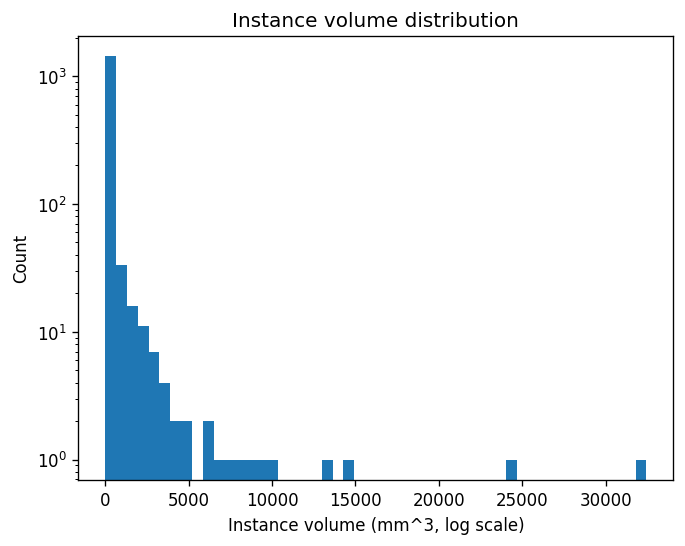

In [63]:
plt.figure()
plt.hist(instances_df["instance_volume"], bins=50)
plt.yscale('log')  # Log scale to see tiny lesions
plt.xlabel("Instance volume (mm^3, log scale)")
plt.ylabel("Count")
plt.title("Instance volume distribution")
plt.show()

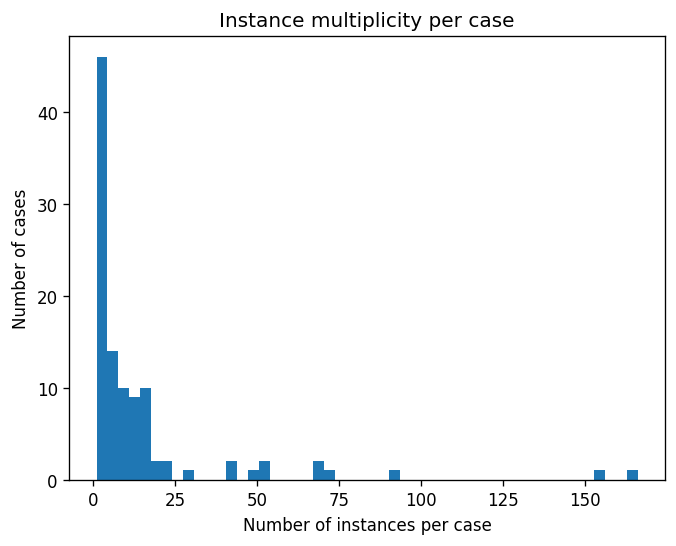

In [64]:
plt.figure()
plt.hist(cases_df["n_instances"], bins=50)
plt.xlabel("Number of instances per case")
plt.ylabel("Number of cases")
plt.title("Instance multiplicity per case")
plt.show()

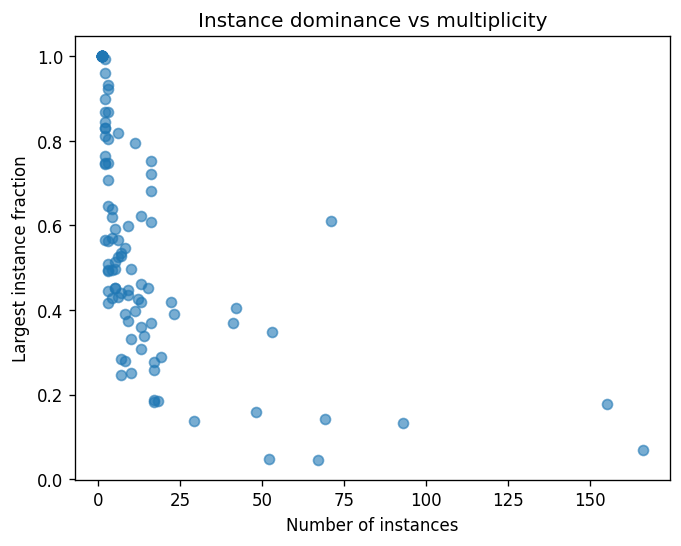

In [65]:
plt.figure()
plt.scatter(
    cases_df["n_instances"],
    cases_df["largest_fraction"],
    alpha=0.6
)
plt.xlabel("Number of instances")
plt.ylabel("Largest instance fraction")
plt.title("Instance dominance vs multiplicity")
plt.show()

In [66]:
OUTPUT_DIR = Path("SBM_metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

cases_df.drop(columns=["instance_volumes_mm3"]).to_csv(
    OUTPUT_DIR / "cases_metrics.csv", index=False
)
instances_df.to_csv(
    OUTPUT_DIR / "instances_metrics.csv", index=False
)
summary_df.to_csv(
    OUTPUT_DIR / "dataset_summary.csv"
)

print("Metrics exported.")

Metrics exported.
